In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import numpy as np
import fiona 
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import matplotlib.image as mpimg
from geopy.geocoders import Nominatim
from time import clock,time
import copy
import warnings

warnings.filterwarnings("ignore")

In [173]:
CrimeIncident = pd.read_csv("CrimeIncident.csv")
StreetLight = pd.read_csv('streetlight-locations.csv')
Property = pd.read_csv('property_assessment_2019.csv')

### Data Cleaning and Reconciliation  
We have three datasets available right now: Streetlight Locations, Property Assessment and Crime Incident Report.  
For Streetlight Locations data, since we only use the feature `Lat` and `Long` and there is no missing value in data, so we do not need too much clean. 

In [174]:
######################## data_clean for Crime Incident #######################

In [175]:
# CrimeIncident
# DELETE NULL AND DUPLICATES
CrimeIncident = CrimeIncident.drop_duplicates()
CrimeIncident = CrimeIncident[CrimeIncident['OFFENSE_CODE_GROUP'].notnull()]
CrimeIncident = CrimeIncident[CrimeIncident['Lat'].notnull()]
CrimeIncident = CrimeIncident[CrimeIncident['Long'].notnull()]
# CrimeIncident['OFFENSE_CODE_GROUP'].isnull().sum()

In [176]:
# DELETE_LIST
delete_list=['INCIDENT_NUMBER','OFFENSE_CODE','OFFENSE_DESCRIPTION','DISTRICT','REPORTING_AREA','SHOOTING','UCR_PART','STREET','Location','YEAR','MONTH','HOUR']
Cleaned_CrimeIncident = CrimeIncident.drop(delete_list,axis = 'columns')

In [177]:
# CRIME GROUP CLASSIFICATION
Others_group = ['INVESTIGATE PERSON','Investigate Person','Medical Assistance','Warrant Arrests','Fire Related Reports','Police Service Incidents','Missing Person Located','Search Warrants','Harbor Related Incidents','Service','Biological Threat','Aircraft','Phone Call Complaints','License Violation','License Plate Related Incidents','Missing Person Reported','Other']
Assault_and_battery = ['Towed','Verbal Disputes','Aggravated Assault','Simple Assault','Harassment','Landlord/Tenant Disputes','Criminal Harassment']
Burglary = ['Burglary - No Property Taken','Vandalism','Residential Burglary','Larceny','Property Lost','Larceny From Motor Vehicle','Property Found','Investigate Property','Commercial Burglary','Recovered Stolen Property','Property Related Damage','Other Burglary','Auto Theft Recovery','HOME INVASION','Auto Theft','Robbery']
Felonies = ['Firearm Violations','Firearm Discovery','Ballistics','Drug Violation','Prisoner Related Incidents','Embezzlement','Prostitution','Homicide','Explosives','Arson','HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','Bomb Hoax','Manslaughter','HUMAN TRAFFICKING']
Fraud = ['Fraud','Confidence Games','Counterfeiting']
Misdemeanors = ['Violations','Disorderly Conduct','Assembly or Gathering Violations','Operating Under the Influence','Evading Fare','Motor Vehicle Accident Response','Gambling','Offenses Against Child / Family','Restraining Order Violations','Liquor Violation']
group_li = [Others_group,Assault_and_battery,Burglary,Felonies,Fraud,Misdemeanors]

In [178]:
def crime_group_clean(i, df, group_li, index_begin, tar_df):
    df_co = df.copy()
    group_i_df = df_co.loc[df_co['OFFENSE_CODE_GROUP'].isin(group_li[i])]
    group_i_df.index = range(index_begin,index_begin+len(group_i_df))
    one_hot = np.array([[0,0,0,0,0,0]])
    one_hot[0][i] = 1
    one_hot = pd.DataFrame(one_hot.repeat(len(group_i_df), axis=0))
    one_hot.index = range(index_begin,index_begin+len(group_i_df))
    group_i_df = pd.concat([group_i_df,one_hot], axis=1)
    tar_df = pd.concat([tar_df,group_i_df],axis=0)
    return index_begin+len(group_i_df),tar_df

In [179]:
new_df = pd.DataFrame()
index_begin = 0
for i in range(len(group_li)):
    index_begin, tar_df = crime_group_clean(i,Cleaned_CrimeIncident, group_li, index_begin, new_df)
    new_df = tar_df

In [180]:
new_df = new_df.rename(columns={0: "class_0", 1: "class_1",2: "class_2",3: "class_3",4: "class_4",5: "class_5"})
new_df.head()

,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE,DAY_OF_WEEK,Lat,Long,class_0,class_1,class_2,class_3,class_4,class_5
0,Investigate Person,2019-09-29 03:45:00,Sunday,42.367690,-71.065863,1,0,0,0,0,0
1,Investigate Person,2019-09-29 01:30:00,Sunday,42.373392,-71.036478,1,0,0,0,0,0
2,Investigate Person,2019-09-29 03:19:00,Sunday,42.311935,-71.073420,1,0,0,0,0,0
3,Medical Assistance,2019-09-29 01:00:00,Sunday,42.355942,-71.062583,1,0,0,0,0,0
4,Missing Person Reported,2019-09-29 01:53:00,Sunday,42.344036,-71.081177,1,0,0,0,0,0


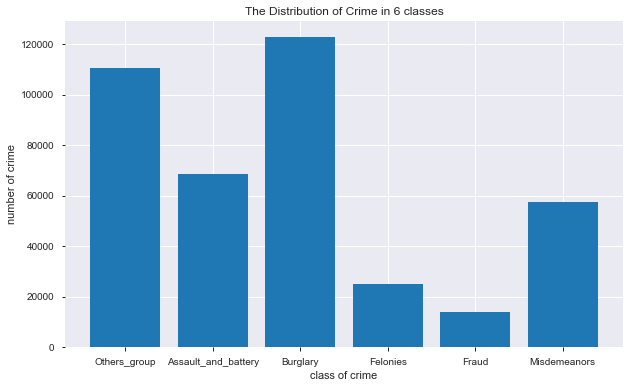

In [181]:
nums=[sum(new_df['class_0']==1),sum(new_df['class_1']==1),sum(new_df['class_2']==1),sum(new_df['class_3']==1),sum(new_df['class_4']==1),sum(new_df['class_5']==1)]
ind = np.arange(6) 
plt.figure(figsize=(10,6))
plt.bar(ind,nums)
plt.ylabel('number of crime')
plt.xlabel('class of crime')
plt.title('The Distribution of Crime in 6 classes')
plt.xticks(ind,('Others_group','Assault_and_battery','Burglary','Felonies','Fraud','Misdemeanors'))
plt.show()

1. In this part, we clean the `CrimeIncident` data and selecting the features we may use in future. `INCIDENT_NUMBER` is the record num and it should not be added in our features because the inner relation between these numbers is useless and may badly affect the prediction. `OFFENSE_CODE` ,`OFFENSE_CODE_GROUP`, and `OFFENSE_DESCRIPTION` are three similar features that describes the offense type. In order to predict the type of crime, we decide to use the `OFFENSE_CODE_GROUP` which has 67 types as our response feature. For `OFFENSE_CODE_GROUP`, from the output.html we can see, the top 10 frequency together is about 60%, which means that if we just use the top 10 values, the model cannot be representative. We manually classify these 67 types into 6 class according the seriosity of the crime: Others_group, Assault_and_battery, Burgrary, Felonies, Fraud, Misdemeanors. After that, we added one-hot to these six groups and treated the processed DataFrame as our new data set. However, there are some missing value in `OFFENSE_CODE_GROUP`, we delete the conresponding rows since the number of missing value is small. 
2. From the figure above, we can see that the felonies and fraud have least number of crime. Burglary is the most frequent type in Boston area and second one is others, the third one is assult and battery.
3. `DISTRICT`, `REPORTING_AREA`, `STREET`, `LAT`, `Long` and `Location` are similar features that indicate the location of the crime. Since the longitude and latitude are the most specific data for position, we keep the `LAT` and `Long` features and delete others.`SHOOTING` is a pretty important factor here, but since there are too many missing value (NAN,397587), we decide to delete this column.    
4. `OCCURRED_ON_DATE`, `YEAR`, `MONTH`,`DAY_OF_WEEK` and `HOUR` are about the time of crime. We keep the most exact value `OCCURRED_ON_DATE` and the value `DAY_OF_WEEK` from which we can infer something like if some type of crime is more likely to happen on some day of the week like weekend or Friday?  
5. To clean the data, we drop the rows where group code, latitude and longitude are missing. In fact, we have 39380 (~9%) missing data for latitude and longitude. It's better to infer the lat and lon from the street or district information. However, our API is not allowed to transfer so many positions. So we dropped these rows.

In [182]:
######################## data_clean for Property #######################

In [183]:
# Property
## Replace NULL with ""
Property['ST_NAME_SUF'].fillna("",inplace= True)
Property = Property[Property['ZIPCODE'].notnull()]
Property['ZIPCODE'] = Property['ZIPCODE'].astype(np.int64)
Property.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
0,502550008,502550000.0,502550000,87,BEACON,ST,2-F,2108,102,CD,...,M,NaN,O,M,W,N,1.0,N,G,A
1,502550010,502550000.0,502550000,87,BEACON,ST,2-R,2108,102,CD,...,NaN,NaN,O,S,W,N,1.0,N,A,A
2,502550012,502550000.0,502550000,87,BEACON,ST,3-F,2108,102,CD,...,S,NaN,O,M,W,N,1.0,N,A,G
3,502550014,502550000.0,502550000,87,BEACON,ST,3-R,2108,102,CD,...,NaN,NaN,O,N,W,N,1.0,S,A,G
4,502550016,502550000.0,502550000,87,BEACON,ST,4,2108,102,CD,...,M,M,O,L,W,C,2.0,N,E,G


In [184]:
delete_list = ['PID', 'CM_ID', 'GIS_ID',
       'UNIT_NUM', 'PTYPE', 'LU', 'OWN_OCC', 'OWNER',
       'MAIL_ADDRESSEE', 'MAIL_ADDRESS', 'MAIL CS', 'MAIL_ZIPCODE', 'AV_LAND',
       'AV_BLDG', 'GROSS_TAX', 'LAND_SF', 'YR_BUILT', 'YR_REMOD',
       'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS', 'STRUCTURE_CLASS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_BTH_STYLE2',
       'R_BTH_STYLE3', 'R_KITCH', 'R_KITCH_STYLE', 'R_KITCH_STYLE2',
       'R_KITCH_STYLE3', 'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND',
       'R_OVRALL_CND', 'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'S_NUM_BLDG',
       'S_BLDG_STYL', 'S_UNIT_RES', 'S_UNIT_COM', 'S_UNIT_RC', 'S_EXT_FIN',
       'S_EXT_CND', 'U_BASE_FLOOR', 'U_NUM_PARK', 'U_CORNER', 'U_ORIENT',
       'U_TOT_RMS', 'U_BDRMS', 'U_FULL_BTH', 'U_HALF_BTH', 'U_BTH_STYLE',
       'U_BTH_STYLE2', 'U_BTH_STYLE3', 'U_KITCH_TYPE', 'U_KITCH_STYLE',
       'U_HEAT_TYP', 'U_AC', 'U_FPLACE', 'U_INT_FIN', 'U_INT_CND', 'U_VIEW']
# ST_NUM ST_NAME ST_NAME_SUF, ZIPCODE,'AV_TOTAL'

For Property Assessment, the features we will use are 'AV_TOTAL' and some position values like ST_NUM, ST_NAME, ST_NAME_SUF and ZIPCODE. So we impute ST_NAME_SUF with empty string and delete 7 rows with missing value of ZIPCODE. Also, we change the data type of ZIPCODE from float to int.
    
Some future concerns:  we need to consider the crimes that happened when there were stree lights on to figure out the importance of streetlight. To do that, we can filter the raw data by selecting the corresponding time in future. In addition, we can make 'DAY_OF_WEEK' 0 or 1 to indicate whether the day is a weekday.


### Visualizations and Summary of EDA

In [185]:
from IPython.display import HTML
HTML(filename='output.html')

Number of variables,17
Number of observations,439016
Missing cells,544225 (7.3%)
Duplicate rows,751 (0.2%)
Total size in memory,56.9 MiB
Average record size in memory,136.0 B
Numeric,6
Categorical,11
Boolean,0
Date,0
URL,0


#### Analysis of the `Crime Profiling` through ` Data Profiling Overview`

##### Dataset info: 

This dataset has 17 feature, and 439016 rows of data. 

From the `Warnings` part we can see, our dataset has 751 (0.2%) duplicate rows. 

For `Lat` and `Long` column, each has 39380 (9.0%) missing values. 

`OCCURRED_ON_DATE` only contains datetime values, but `YEAR`, `MONTH`, `DAY_OF_WEEK`, `HOUR` also contain some of the same records. 

`OFFENSE_CODE` has 233 distinct values, but we can use `OFFENSE_CODE_GROUP` to integrate these values.

`OFFENSE_DESCRIPTION` column has a high cardinality, which has 283 distinct values. So, we might delete this column because of it has less relation to the `OFFENSE_CODE_GROUP`, whcih is we want to predict.

`REPORTING_AREA` and `STREET` also have 880 and 4993 distinct values, and `STREET`has 13674 (3.1%) missing values. However, the type of `DISTRICT` is 13, which is too small, so the area of each DISTRICT is too large, which limits the accuracy of the model. It is also difficult to map the latitude and longitude of each data to each `DISTRICT` because the boundaries of each `DISTRICT` are irregular. Compared to using these two columns to fit our model, we prefer to just use `Long` and `Lat` instead.

`SHOOTING` column has 425093 (96.8%) missing values, so we tend to delete this column of data.

`UCR_PART` has 12286 (2.8%) missing values. After looking up the data, we feel that the data in this column is also very small in connection with the results we want to predict, and can also be replaced by the data of `OFFENSE_CODE_GROUP`.

##### Variables

`DAY_OF_WEEK`: the frequency of each day is, Sunday: 12.6%, Monday: 14.3%, Tuesday: 14.5%, Wednesday: 14.7%, Thursday: 14.6%, Friday: 15.2%. From the frequency we can see, the variance is small.

`HOUR`: the mean of this column is 13.11154263. From the histogram, we can see that from 1 am to 7am, the crime rate is low, and the most of crime happended between 8 am to 22 pm.

`Lat`: the mean and standard deviation are 42.22163358 and 2.084320084. And the 5-th percentile and 95-th percentile are 42.2680362 and 42.37172781. The Q1 and Q3 are 42.29710452 and 42.34854636. The Minimum and Maximum are -1 and 42.39504158, which means that there may be some data points that may be abnormal. All the above data means `Lat` has small variance. However, instead of normalizing the data, we should keep the original value of it. The data in this column has a special geographical significance, and after normalization, the geographic features of these data will be lost. In particular, this column of data is also a common feature of the other two data sets and this data set, and is very important data.

`Long`: the mean and standard deviation are -70.92043156 and 3.371578779. And the 5-th percentile and 95-th percentile are -71.14432384 and -71.04003478. The Q1 and Q3 are -71.09722321 and -71.06258333. The Minimum and Maximum are -71.17867378 and -1, which means that there may be some data points that may be abnormal. All the above data means `Lat` has small variance. However, instead of normalizing the data, we should keep the original value of it. The data in this column has a special geographical significance, and after normalization, the geographic features of these data will be lost. In particular, this column of data is also a common feature of the other two data sets and this data set, and is very important data.

`MONTH`: the mean of this column is 6.745988757. From the histogram, we can see that from February to August, the number of crimes is on the rise, and from September to January, the number of crimes is gradually decreasing. The highest point is from July to November, and the lowest peak is in February. A possible cause of this phenomenon is that Boston's low temperatures during the winter are not conducive to criminal activity.

`OFFENSE_CODE_GROUP`: the ten crimes with the highest incidence rate accounted for only 62.5% of all crimes. From the perspective of individual crimes, the highest incidence is the Motor Vehicle Accident Response, which accounts for only 11.3% of all crimes. So, from the above analysis, we have to re-integrate these groups into six larger groups.

#### Visualization of Streetlight Position in Boston

In [10]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
contour = gpd.read_file('Contours/Contours.shp')

In [12]:
light_locs = [Point(xy) for xy in zip(StreetLight['Long'], StreetLight['Lat'])]
crs = {'init':'espg:4326'}
light_df = gpd.GeoDataFrame(StreetLight, crs=crs, geometry=light_locs)
light_df.head()

,the_geom,OBJECTID,TYPE,Lat,Long,geometry
0,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.353159,-71.076044,POINT (-71.07604 42.35316)
1,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.353348,-71.075382,POINT (-71.07538 42.35335)
2,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.353521,-71.074775,POINT (-71.07477 42.35352)
3,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.353556,-71.074404,POINT (-71.07440 42.35356)
4,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.353811,-71.073621,POINT (-71.07362 42.35381)


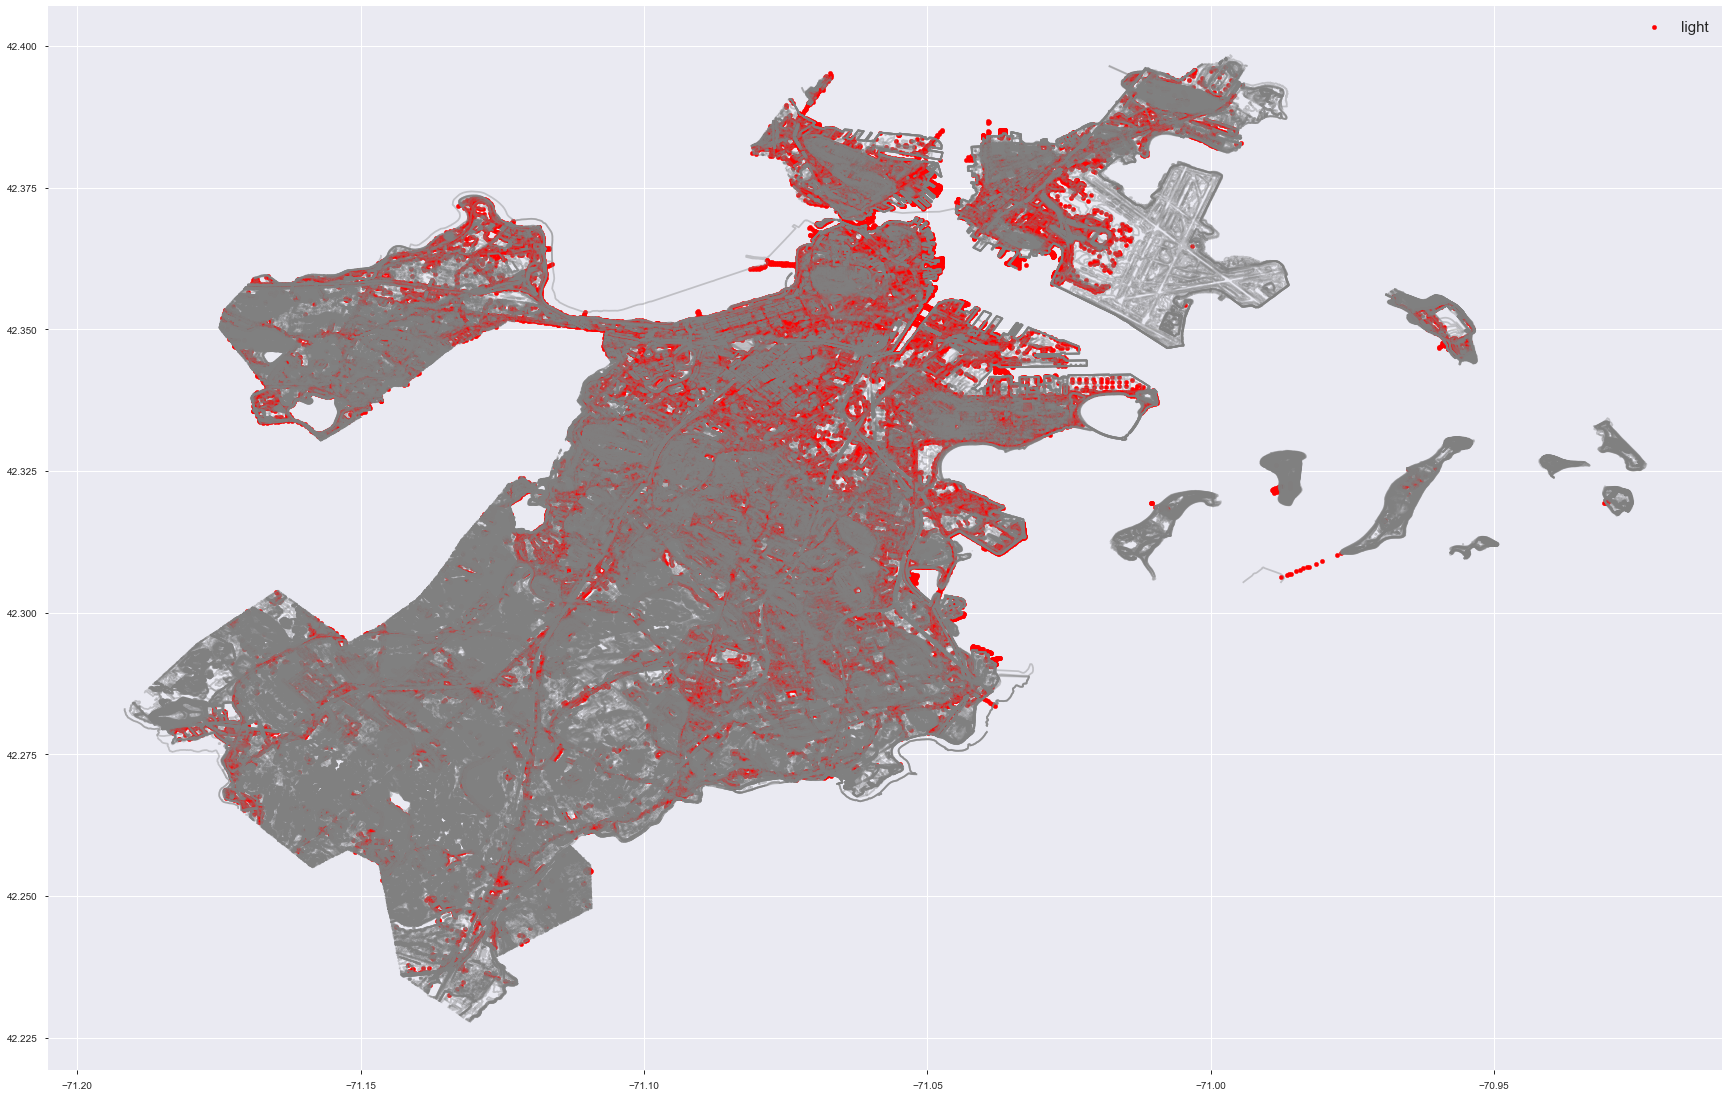

In [13]:
fig, ax = plt.subplots(figsize=(30,30))
contour.plot(ax=ax, alpha=0.4, color='grey')
light_df.plot(ax=ax, markersize=20, color="red", marker='o',label='light')
plt.legend(prop={'size':15})
plt.savefig('boston-lights-contour.png')
# img = mpimg.imread('boston-lights-contour.png')
# imgplot = plt.imshow(img)
# plt.show()

The graph shown is the distribution of streetlight in boston. Given the latitude and longtitude of streetlight from the dataset, we draw each indivudal streetlight in the city. Notice that most of streetlights distributed over the central of the city while in the outer area the distribution is relatively sparse.

In [20]:
# make them to strs
property_df = copy.deepcopy(Property)
property_df['ZIPCODE'] = property_df['ZIPCODE'].astype('str')
property_df['ST_NUM'] = property_df['ST_NUM'].astype('str')
property_df['ST_NAME'] = property_df['ST_NAME'].astype('str')
property_df['ST_NAME_SUF'] = property_df['ST_NAME_SUF'].astype('str')

In [21]:
#generate lat and long for all property
geolocator = Nominatim()
property_df['ST_FULL_NAME'] = property_df[['ST_NUM', 'ST_NAME', 'ST_NAME_SUF']].apply(lambda x: ' '.join(x), axis=1)
property_df['ST_FULL_NAME'] = property_df['ST_FULL_NAME'].astype('str') + ', Boston MA, '
property_df['ST_FULL_NAME'] = property_df['ST_FULL_NAME'] + property_df['ZIPCODE']
property_df.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,ST_FULL_NAME
0,502550008,502550000.0,502550000,87,BEACON,ST,2-F,2108,102,CD,...,NaN,O,M,W,N,1.0,N,G,A,"87 BEACON ST, Boston MA, 2108"
1,502550010,502550000.0,502550000,87,BEACON,ST,2-R,2108,102,CD,...,NaN,O,S,W,N,1.0,N,A,A,"87 BEACON ST, Boston MA, 2108"
2,502550012,502550000.0,502550000,87,BEACON,ST,3-F,2108,102,CD,...,NaN,O,M,W,N,1.0,N,A,G,"87 BEACON ST, Boston MA, 2108"
3,502550014,502550000.0,502550000,87,BEACON,ST,3-R,2108,102,CD,...,NaN,O,N,W,N,1.0,S,A,G,"87 BEACON ST, Boston MA, 2108"
4,502550016,502550000.0,502550000,87,BEACON,ST,4,2108,102,CD,...,M,O,L,W,C,2.0,N,E,G,"87 BEACON ST, Boston MA, 2108"


In [22]:
def property_find_long_lat(street_name):
    try:
        location = geolocator.geocode(street_name, timeout=5)
        return location.longitude, location.latitude
    except:
        return None, None

In [26]:
#property_df['Lat'], property_df['Long'] = zip(*property_df['ST_FULL_NAME'].map(property_find_long_lat))
N = 10
geolocator = Nominatim()
N_property_df = property_df.sample(n=N, random_state=1)
#N_property_df['Lat'], N_property_df['Long'] = zip(*N_property_df['ST_FULL_NAME'].map(property_find_long_lat))

temp = np.array(N_property_df['ST_FULL_NAME'])
property_find_long_lat(temp[0])
long_list = []
lat_list = []
start_time = time()
for i in range(N):
    long, lat = property_find_long_lat(temp[i])
    long_list.append(long)
    lat_list.append(lat)
end_time = time()
print("time collapsed: ", end_time - start_time)
N_property_df['Lat'], N_property_df['Long'] = lat_list, long_list

time collapsed:  3.946730375289917


The second graph we are trying to plot is the distribution of all the property in Boston. However, the obstacle of ploting this is we are only given the street name of each property rather than accurate position, so to get the exact longtitude and latitude we need to request online MAP API such as GoogleV3 to get all the data. Our code runs perfectly, but since we only have around 1000 allowance of API request per day, there is no chance we get all the position data for 174668 property in such a short time. Thus, we can't finish ploting the graph this time and we decide to leave the code for reference. 

### Baseline model
The baseline model we use are linear regression on our selected feature space. specifically, given CRIME_INCIDENT_REPORTS data, we want to predict the number of crime would happen in each selected region using linear regression model. We use 36 grids to calculate the number of street lights and the number of crimes so as to find the relationship between lights and crimes.

We’re still in the process of determining the evaluation plans for our more ambitious models, such as a RNN or a HMM.

In [191]:
from sklearn.model_selection import train_test_split

In [188]:
#assign grid number to given pos
#grid idx: 0-35
def find_grid(long, lat):
    m,n = 4,9
    x,y = -1,-1
    long_candidate = np.linspace(-71.10, -71.05, num=m+1)
    lat_candidate = np.linspace(42.300, 42.350, num=n+1)
    for i in range(m):
        if long>=long_candidate[i] and long<long_candidate[i+1]:
            x = i
            break
    for j in range(n):
        if lat>=lat_candidate[j] and lat<lat_candidate[j+1]:
            y = j
            break
    if x>=0 and y>=0:
        return x*n+y
    else:
        return -1

In [168]:
#assign streetlight to candidate grids
streetlight_grid_count = [0]*36
for long, lat in zip(StreetLight['Long'], StreetLight['Lat']):
    idx = find_grid(long,lat)
    if idx >= 0:
        streetlight_grid_count[idx] += 1

#assign crime to candidate grids
crimeIncident_grid_count = [0]*36
for long, lat in zip(CrimeIncident['Long'], CrimeIncident['Lat']):
    idx = find_grid(long,lat)
    if idx >= 0:
        crimeIncident_grid_count[idx] += 1

training data score is: 0.3140936545051064


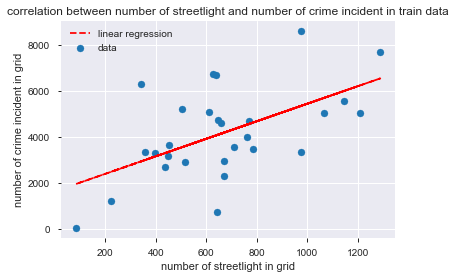

In [197]:
# idx from 0-35
from sklearn.linear_model import LinearRegression
X = np.reshape(streetlight_grid_count, (-1, 1))
y = crimeIncident_grid_count
X_train, X_test, y_train, y_test =train_test_split(X,y, 
                                         test_size = 0.2, 
                                          random_state = 109)
reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_train)
print("training data score is:", reg.score(X_train, y_train))

# plot 
plt.scatter(X_train,y_train, label='data')
plt.plot(X_train, pred, 'r--', label='linear regression')
plt.xlabel('number of streetlight in grid')
plt.ylabel('number of crime incident in grid')
plt.title('correlation between number of streetlight and number of crime incident in train data')
plt.legend()
plt.show()

test data score is: 0.003557522810740399


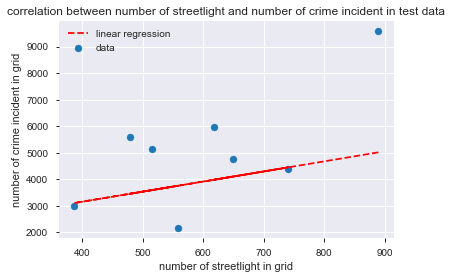

In [198]:
pred_test = reg.predict(X_test)
print("test data score is:", reg.score(X_test, y_test))

# plot 
plt.scatter(X_test,y_test, label='data')
plt.plot(X_test, pred_test, 'r--', label='linear regression')
plt.xlabel('number of streetlight in grid')
plt.ylabel('number of crime incident in grid')
plt.title('correlation between number of streetlight and number of crime incident in test data')
plt.legend()
plt.show()

### A revised project question based on the insights you gained through EDA  

&nbsp;&nbsp; First, from the last milestone, our goal was exploring the correlation with the presence of light on the streets and the locations of crimes and the relationship between investigate economic disparity and crime. From this milestone, we find that the relationship between street lights and the number of crimes is not strong enough to let us predict the crime number only using street light numbers, So we may add more features in our final project to improve the accuracy of prediction.

&nbsp;&nbsp; Second, the proverty data does not include the `LAT` an `LONG` which means we need to find appropriate APIs to transfer these. However, these APIs have limitation about the usage, so our next step is to find another way to implement this tranformation.

&nbsp;&nbsp; Third, we built a baseline mode which performs low accuracy in both train and test set. We think the biggest problem for this model is the lack of features. Another problem may come from the linearity because the relationship between lights and crime is not linear. Thus, we will try different model in this case.

&nbsp;&nbsp; Forth, we find the types of `District` are too samll and the number of `street` is too large. So we choose the `LAT` an `LONG` as the connection among these datasets since we want to use `LAT` and `LONG` to split Bostion area into $n$ grids where $n$ is critical feature we may determine in the future. And we will calcuate the average property of houses and number of street lights in each grid. These two important features will greatly improve the accuracy of our models.

&nbsp;&nbsp; Fifth, we found that only using property of houses and street lights datasets is not enough. Because there are some other factors might effect the occurence of the crimes, such as the population of the grids and the number of police stations within the grids. So, we want to add more datasets which might have some relationship to the crime types.

&nbsp;&nbsp; Finally, we will try to explore the predictive ability of property values and streetlight locations toward crime incident types, and maybe output a crime map in Cambridge and Boston area based on our prediction.     